In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

import timm
from facenet_pytorch import MTCNN

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from tqdm import tqdm
path = "/data/komedi/dataset/dataset_frontal_27pt"
file_list = os.listdir(path)

name_list = []
for idx, i in enumerate(tqdm(range(16800))):
    name_list.append(os.path.join(path,file_list[i]))

100%|██████████| 16800/16800 [00:00<00:00, 733208.89it/s]


In [69]:
csv_lists = []
for i in range(len(name_list)):
    csv_list = []
    csv_list.append(os.path.splitext(file_list[i])[0])
    csv_list.append(file_list[i].split('_')[1])                
    csv_list.append(file_list[i].split('_')[2])
    csv_list.append(name_list[i])
    
    csv_lists.append(csv_list)

In [71]:
df = pd.DataFrame(csv_lists)
df.to_csv('test.csv', header=None, index=None)

In [63]:
# file_list[i].split('_')


('19070922_S002_L8_E01_C7',
 'S002',
 'L8',
 '/data/komedi/dataset/dataset_frontal_27pt/19070922_S002_L8_E01_C7.jpg')

In [61]:
file_list[i].split('_')

['19070922', 'S002', 'L8', 'E01', 'C7.jpg']

In [90]:
def timm_Net_54(model_name, pretrained=None, num_classes=54):
    model = timm.create_model(
        model_name=model_name,
        pretrained=False,
        num_classes=num_classes
        )

    if not pretrained==None:
        model.eval()
        model.load_state_dict(torch.load(pretrained, map_location = 'cpu'), strict=False)
        
    return model

def mtcnn(image, margin=0): #PIL
    numpy_image =  np.array(image)
    mtcnn = MTCNN(
    image_size=512, margin=margin, min_face_size=100,
    thresholds=[0.1,0.1,0.1], factor=0.5, post_process=True,
    device='cpu', select_largest=True
    )
    
    bbox, _ = mtcnn.detect(numpy_image)
    crop_area = (bbox[0][0]-100, # get bbox area with margin
                 bbox[0][1]-100,
                 bbox[0][2]+100,
                 bbox[0][3]+100)
    pil_image = Image.fromarray(numpy_image)
    crop_img = pil_image.crop(crop_area)
    
    return crop_img, bbox, np.array(crop_img).shape[0], np.array(crop_img).shape[1]

In [48]:
model_name = "swin_base_patch4_window7_224"
pretrained = "/data/komedi/pretrained_model/2022-07-07/frontal_27pt_swin_base_patch4_window7_224_100.pt"
model = timm_Net_54(model_name, pretrained)

In [91]:
def run(i):
    image = Image.open(name_list[i])

    crop_img, bbox, h, w = mtcnn(image)
    resize_img = TF.resize(crop_img, (224,224))
    image_tensor = TF.to_tensor(resize_img)
    image_tensor = image_tensor.unsqueeze(0)

    predict = model(image_tensor)

    landmarks = ((predict.view(-1,2)+0.5)).detach().numpy().tolist()
    landmarks = np.array([(int(x*w), int(y*h)) for (x, y) in landmarks if 0 <= x <= 224 and 0 <= y <= 224])
    return landmarks, bbox

In [101]:
csv_lists = []
for _, i in enumerate(tqdm(range(len(name_list)))):
    # if i > 1:
    #     break
    try:
        csv_list = []
        csv_list.append(os.path.splitext(file_list[i])[0])
        csv_list.append(file_list[i].split('_')[1])                
        csv_list.append(file_list[i].split('_')[2])
        csv_list.append(name_list[i])
        landmarks, bbox = run(i)
        for bb in bbox[0]:
            csv_list.append(int(bb))
        for x,y in landmarks:
            csv_list.append((x,y))
        csv_lists.append(csv_list)
        df = pd.DataFrame(csv_lists)
        df.to_csv('test.csv', header=None, index=None)
    except TypeError:
        pass

 18%|█▊        | 3082/16800 [2:28:45<11:34:57,  3.04s/it]

In [99]:
df = pd.DataFrame(csv_lists)
df.to_csv('test.csv', header=None, index=None)

27

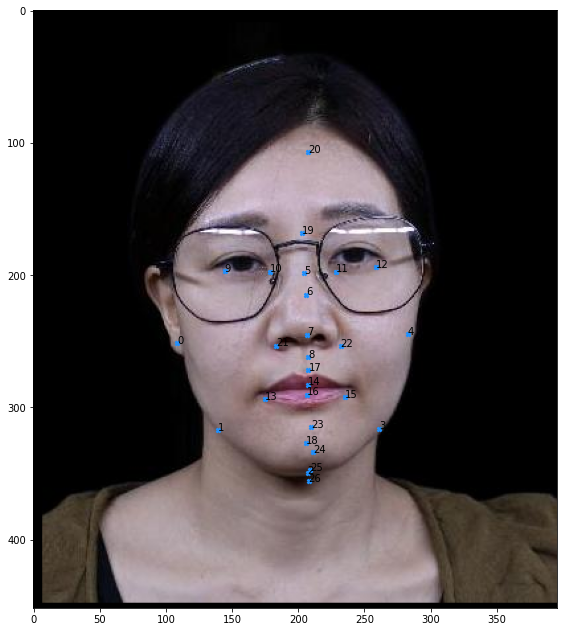

In [50]:
plt.figure(figsize=(11,11))
for idx in range(len(landmarks)):
    plt.scatter(landmarks[idx][0],landmarks[idx][1],s=20,c='dodgerblue',marker='X')
    
    plt.annotate(idx, (landmarks[idx][0],landmarks[idx][1]))
plt.imshow(crop_img)